In [1]:
from math import pi
import numpy as np
import matplotlib.pyplot as plt
import wavio
from scipy import fftpack, signal
import IPython

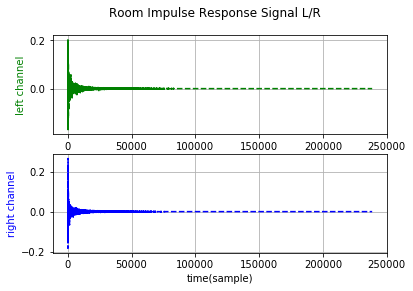

In [2]:
sr = 44100

wav = wavio.read("large_choir_hall.wav")

left_channel = wav.data[:, 0]
left_channel = left_channel.astype(np.float32, order='C') / 32767.0

right_channel = wav.data[:, 1]
right_channel = right_channel.astype(np.float32, order='C') / 32767.0

x_axis = np.arange(len(left_channel))

plt.figure(1)
plt.suptitle('Room Impulse Response Signal L/R')

plt.subplot(211)
plt.plot(x_axis, left_channel, 'g--')
plt.ylabel('left channel', color='g')
plt.grid()

plt.subplot(212)
plt.plot(x_axis, right_channel, 'b--')
plt.ylabel('right channel', color='b')
plt.grid()

plt.xlabel(r'time(sample)')

plt.show()

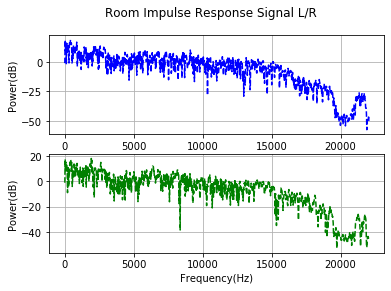

In [4]:
left_time = np.arange(len(left_channel))*1.0/sr
left_power = 20*np.log10(np.abs(np.fft.rfft(left_channel[:2048])))
left_frequency = np.linspace(0, sr/2.0, len(left_power))

right_time = np.arange(len(right_channel))*1.0/sr
right_power = 20*np.log10(np.abs(np.fft.rfft(right_channel[:2048])))
right_frequency = np.linspace(0, sr/2.0, len(right_power))

plt.figure(1)
plt.suptitle('Room Impulse Response Signal L/R')

plt.subplot(211)
plt.plot(left_frequency, left_power, 'b--')
plt.ylabel("Power(dB)")
plt.grid()

plt.subplot(212)
plt.plot(right_frequency, right_power, 'g--')
plt.xlabel("Frequency(Hz)")
plt.ylabel("Power(dB)")
plt.grid()

plt.show()